# GPU-Accelerated Curve Fitting with Theseus

In [1]:
import numpy as np
from theseusqfls import genplanck_profiling
import torch
from scipy.optimize import curve_fit
import time
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
energy = np.linspace(1.65, 1.75, 50)
qfls = 1.12*np.ones((1024, 1024)) + 0.01*(np.random.random((1024, 1024)) - 0.5)
gamma = 0.02*np.ones((1024, 1024)) + 0.002*(np.random.random((1024, 1024)) - 0.5)
theta = 1.5*np.ones((1024, 1024)) + 0.05*(np.random.random((1024, 1024)) - 0.5)
bandgap = 1.6*np.ones((1024, 1024)) + 0.05*(np.random.random((1024, 1024)) - 0.5)
pl = np.zeros((energy.size, qfls.shape[0], qfls.shape[1]))

In [3]:
exp_energy, exp_pl = genplanck_profiling.import_hyperspectral('data/example_photometric.h5')
exp_energy_crop, exp_pl_crop = genplanck_profiling.crop_data(exp_energy, exp_pl)
init_guesses = [1.2, 0.025, 1.5, 1.7]
points = [255, 511, 767]
guesses = np.zeros((4, len(points), len(points)))
for i in range(len(points)):
    for j in range(len(points)):
        guesses[:, i, j], __ = curve_fit(genplanck_profiling.gen_planck, exp_energy_crop, exp_pl_crop[:, i, j].squeeze(), p0=init_guesses)
guesses = list(np.mean(guesses, axis=(1, 2)))

C:\Users\cbc37\Desktop\theseusqfls\theseusqfls\genplanck_profiling.py:104: RuntimeWarning: invalid value encountered in sqrt
  part3 = (1 - math.e ** (-40 * np.sqrt(gamma) * eval_interp((energy - bandgap) / gamma, theta)))


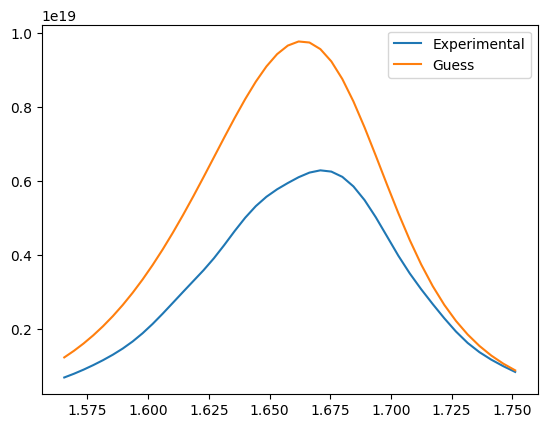

In [4]:
fig, ax = plt.subplots()
ax.plot(exp_energy_crop, np.mean(exp_pl_crop, axis=(1, 2)), label='Experimental')
ax.plot(exp_energy_crop, genplanck_profiling.gen_planck(exp_energy_crop, guesses[0], guesses[1], guesses[2], guesses[3]), label='Guess')
ax.legend()

In [7]:
result = genplanck_profiling.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=1, verbose=False)

  0%|          | 0/512 [10:23<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
arr = np.reshape(result['qfls'], (1024, 1024))
fig, ax = plt.subplots()
im = ax.imshow(arr, vmin=np.nanpercentile(arr, 1), vmax=np.nanpercentile(arr, 99), cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis('off')
fig.tight_layout()
plt.savefig('figures/example_qfls.png', dpi=300, bbox_inches='tight')
plt.show()